## Walktimes to MERGED
# Introduction

In this tutorial we will analyse walk times from bike_TE points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. MERGEDs can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including MERGED (https://open.toronto.ca/dataset/ttc-routes-and-schedules/), the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One bike_TE Repository bike_TE point data (https://open.toronto.ca/dataset/bike_TE-points-municipal-toronto-one-bike_TE-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/).

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto bike_TE point data contains over 500,000 bike_TE points within the city. A readme file is also included which explains the each of the attributes.

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).

In [ ]:
!pip install geopandas

In [ ]:
!pip install psycopg2

In [ ]:
!pip install pandana

In [ ]:
!pip install basemap --user

In [ ]:
!pip install geoalchemy2

In [ ]:
!pip install mapclassify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import Polygon, LineString, Point, box
%matplotlib inline

## Step 1: Importing and Cleaning Data
# Importing Data
We can read the MERGED text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, bike_TE and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

# Read MERGED Data
Read the MERGED data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [2]:
# Let's check out the .shp file instead (same dataset)
MERGED = gpd.read_file('merged.shp')
MERGED

,point_of_i,x,y,geometry
0,Child Care Center,304461.400215,4.828672e+06,POINT (304461.400 4828671.905)
1,Child Care Center,311217.445605,4.840433e+06,POINT (311217.446 4840433.213)
2,Child Care Center,330918.335077,4.850205e+06,POINT (330918.335 4850204.630)
3,Child Care Center,314172.948870,4.834207e+06,POINT (314172.949 4834207.161)
4,Child Care Center,322448.989348,4.840141e+06,POINT (322448.989 4840140.901)
...,...,...,...,...
1328,Youth Health Service,320164.828450,4.851127e+06,POINT (320164.828 4851126.963)
1329,Youth Health Service,296275.475450,4.843733e+06,POINT (296275.475 4843733.341)
1330,Youth Health Service,313405.787612,4.838395e+06,POINT (313405.788 4838395.286)
1331,Youth Health Service,306322.188598,4.835810e+06,POINT (306322.189 4835809.701)


In [4]:
MERGED.crs

<Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

### Explore MERGED

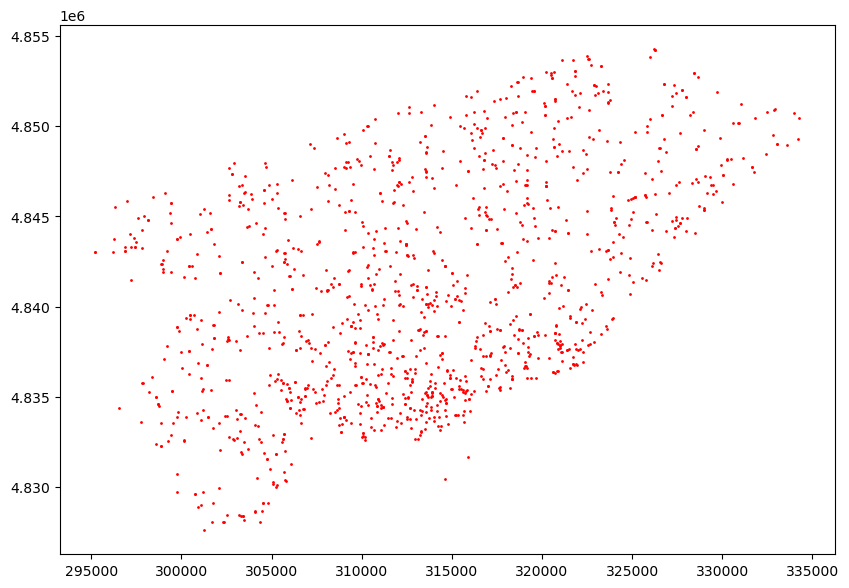

In [5]:
ax = MERGED.plot(figsize=(10, 10),color='red', markersize =1)

## Read Pedestrian Network Data
Read the Pedestrian Network line shape file and reproject to EPSG 2019

In [6]:
# reading pednet file
pednet = gpd.read_file("Pedestrian Network Data - 4326.zip")
pednet

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry
0,696841,1,Local,7,Sidewalk on both sides,0,None,NaN,None,93.867680,129.824322,"LINESTRING (-79.56396 43.73782, -79.56293 43.7..."
1,696842,2,Collector,7,Sidewalk on both sides,0,None,NaN,None,32.546284,44.903807,"LINESTRING (-79.56792 43.63618, -79.56752 43.6..."
2,696843,3,None,2,Sidewalk on north side only,0,None,NaN,None,117.669206,162.522572,"LINESTRING (-79.37791 43.67845, -79.37652 43.6..."
3,696844,4,None,7,Sidewalk on both sides,0,None,NaN,None,223.269710,309.035596,"LINESTRING (-79.51852 43.70501, -79.51674 43.7..."
4,696845,5,Local,7,Sidewalk on both sides,0,None,NaN,None,201.335648,278.478601,"LINESTRING (-79.30122 43.77484, -79.29880 43.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...
87100,783941,87101,Walkway,11,City walkway,1,ts,1430.0,ts,32.249129,44.584927,"LINESTRING (-79.57840 43.73537, -79.57803 43.7..."
87101,783942,87102,Walkway,11,City walkway,1,ts,1174.0,ts,26.786411,37.023492,"LINESTRING (-79.57050 43.71929, -79.57019 43.7..."
87102,783943,87103,Walkway,11,City walkway,1,ts,888.0,ts,32.846849,45.381530,"LINESTRING (-79.56002 43.69689, -79.55964 43.6..."
87103,783944,87104,Walkway,11,City walkway,1,ts,2137.0,ts,30.031629,41.511419,"LINESTRING (-79.57363 43.72572, -79.57327 43.7..."


In [7]:
pednet.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
pednet = pednet.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
# remove length column to avoid confusion
# pednet = pednet[['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk', 'cwalk_type', 'px', 'px_type','geometry']]
pednet = pednet[['FIELD_1', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9','geometry']]
pednet

,FIELD_1,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,geometry
0,696841,Local,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (299647.480 4843993.305, 299730.645..."
1,696842,Collector,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (299319.487 4832701.797, 299351.915..."
2,696843,None,2,Sidewalk on north side only,0,None,NaN,None,"LINESTRING (314644.016 4837403.152, 314756.028..."
3,696844,None,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (303307.301 4840346.899, 303450.851..."
4,696845,Local,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (320802.305 4848122.923, 320996.750..."
...,...,...,...,...,...,...,...,...,...
87100,783941,Walkway,11,City walkway,1,ts,1430.0,ts,"LINESTRING (298484.120 4843722.537, 298514.329..."
87101,783942,Walkway,11,City walkway,1,ts,1174.0,ts,"LINESTRING (299119.187 4841934.761, 299144.363..."
87102,783943,Walkway,11,City walkway,1,ts,888.0,ts,"LINESTRING (299961.620 4839445.526, 299992.729..."
87103,783944,Walkway,11,City walkway,1,ts,2137.0,ts,"LINESTRING (298868.080 4842649.076, 298896.374..."


## Explore the Pedestrian Network Data
Create bar plot and plots of pednet

Create a bar plot showing the distribution of road types

<AxesSubplot:title={'center':'Pednet Road Type Distribution'}, xlabel='Road Types ', ylabel='Number'>

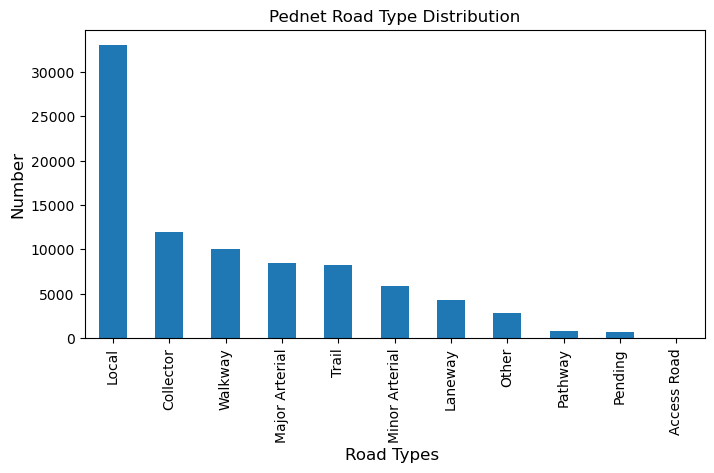

In [10]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.FIELD_3.value_counts().plot.bar()

### Create a plot of the city wide Pedestrian Network

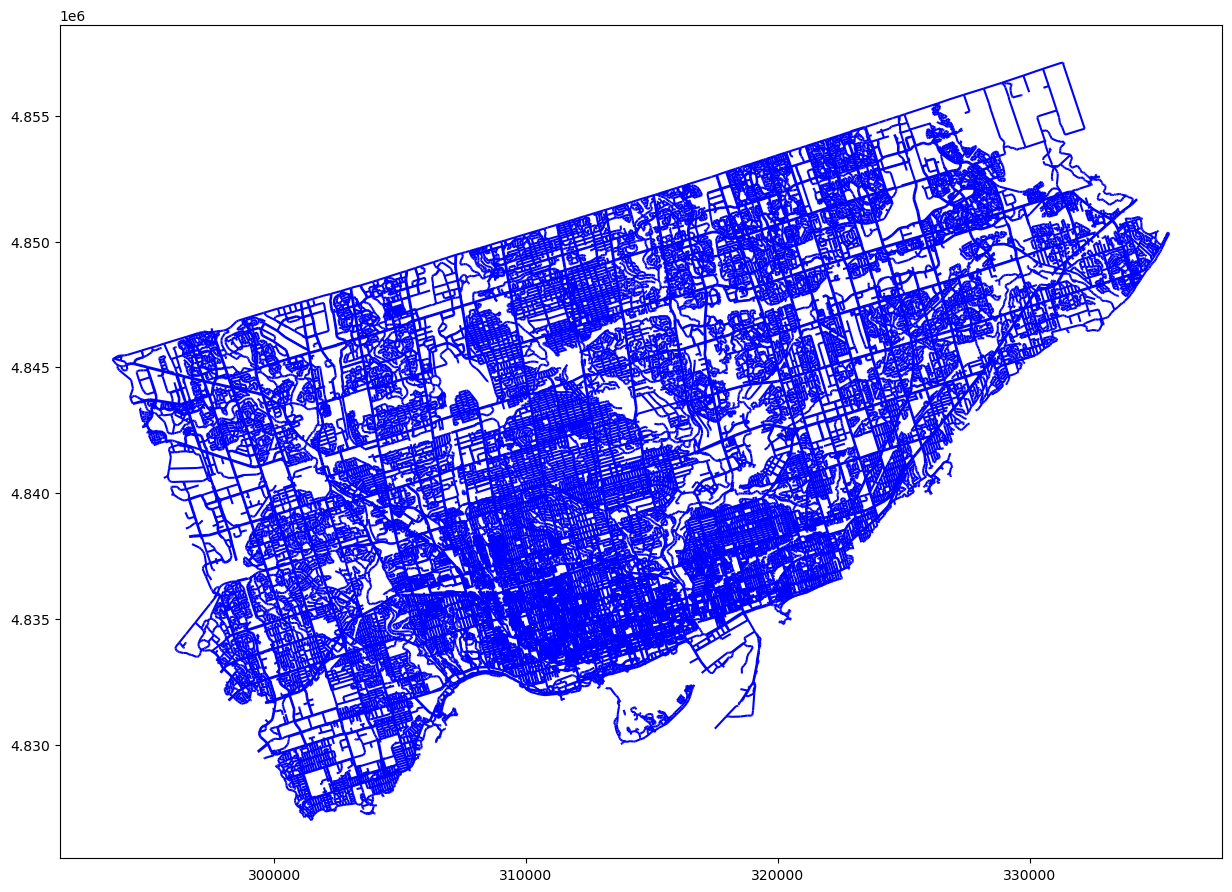

In [11]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the Pedestrian Network at the city block level
In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.

[(311000.0, 312000.0), (4834000.0, 4835000.0)]

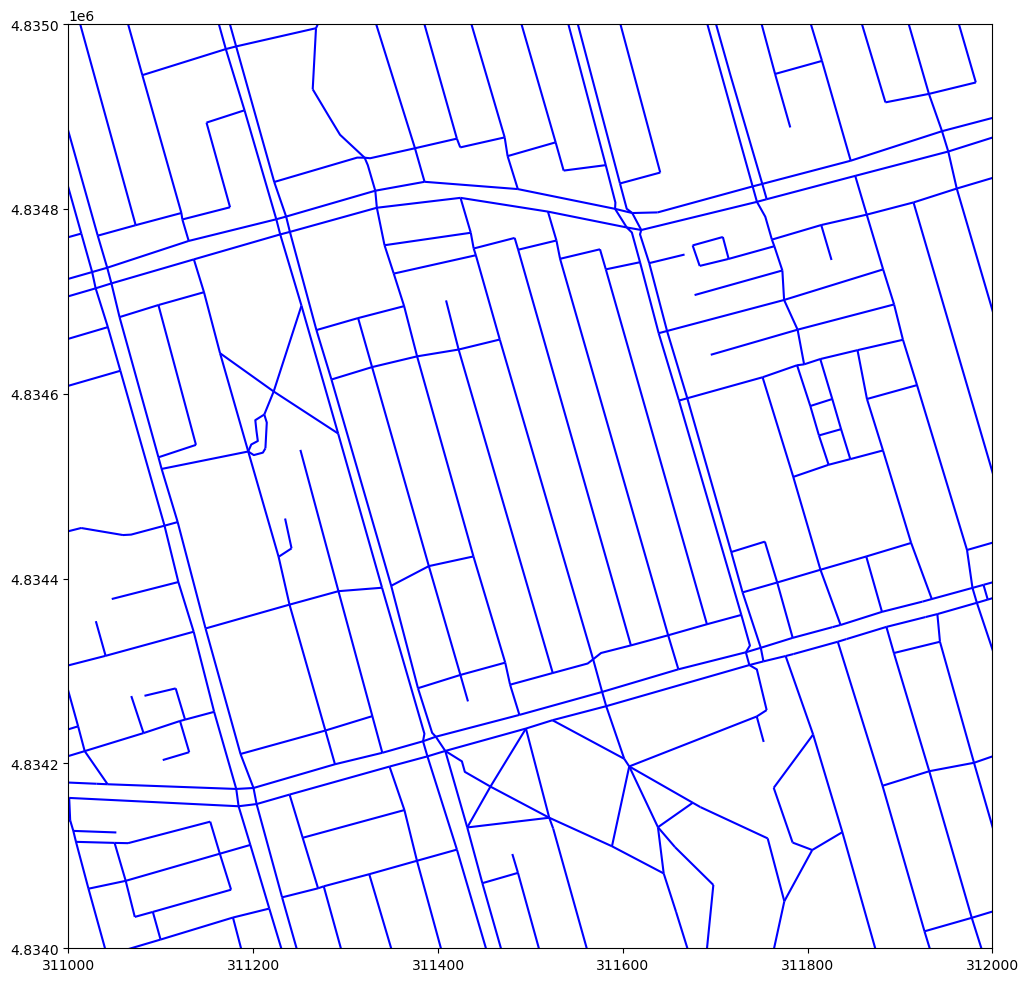

In [12]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

## Load TTC Stop Data
Read the TTC Stop file and reproject to EPSG 2019

In [13]:
# reading municipal bike_TE point shape file
# https://open.toronto.ca/dataset/bike_TE-points-municipal-toronto-one-bike_TE-repository/
# Go to Download Data
bike_TE = gpd.read_file("BICYCLE_TRAIL_ENTRANCE_WGS84.shp")
bike_TE

,ST_NAME,CR_ST_NAME,TRAIL_NAME,ACCESSIBLE,TYPE,STAIR_NUM,GRADE,IMPROVEMNT,SCOPE_WORK,X,Y,LONGITUDE,LATITUDE,OBJECTID,geometry
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,None,None,0,0,None,None,324474.245,4845739.724,-79.255494,43.753354,75,POINT (-79.25549 43.75335)
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,None,None,0,0,None,None,324492.968,4845777.592,-79.255260,43.753694,76,POINT (-79.25526 43.75369)
2,McCowan Rd,St Andrews Rd,Gatineau Trail,None,None,0,0,None,None,325155.599,4846495.005,-79.247004,43.760134,77,POINT (-79.24700 43.76013)
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,None,None,0,0,None,None,325851.462,4847064.897,-79.238340,43.765244,79,POINT (-79.23834 43.76524)
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,None,None,0,0,None,None,326139.506,4847321.038,-79.234752,43.767541,80,POINT (-79.23475 43.76754)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,None,None,0,0,None,None,324083.364,4846499.405,-79.260321,43.760202,513,POINT (-79.26032 43.76020)
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,None,None,0,0,None,None,327610.038,4851417.555,-79.216314,43.804371,543,POINT (-79.21631 43.80437)
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,None,None,0,0,None,None,320347.992,4851022.155,-79.306581,43.800999,574,POINT (-79.30658 43.80100)
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,None,None,0,0,None,None,318963.445,4851542.278,-79.323774,43.805708,602,POINT (-79.32377 43.80571)


In [14]:
# change column names from upper to lower case
bike_TE.columns = map(str.lower, bike_TE.columns)

In [15]:
#include columns needed for the project
bike_TE = bike_TE[['st_name', 'cr_st_name','trail_name','x','y','longitude','latitude','objectid','geometry']]
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (-79.25549 43.75335)
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (-79.25526 43.75369)
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (-79.24700 43.76013)
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (-79.23834 43.76524)
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (-79.23475 43.76754)
...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (-79.26032 43.76020)
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (-79.21631 43.80437)
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (-79.30658 43.80100)
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (-79.32377 43.80571)


In [16]:
bike_TE.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
bike_TE = gpd.GeoDataFrame(bike_TE, crs=crs, geometry='geometry')
bike_TE = bike_TE.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore bike_TE point data

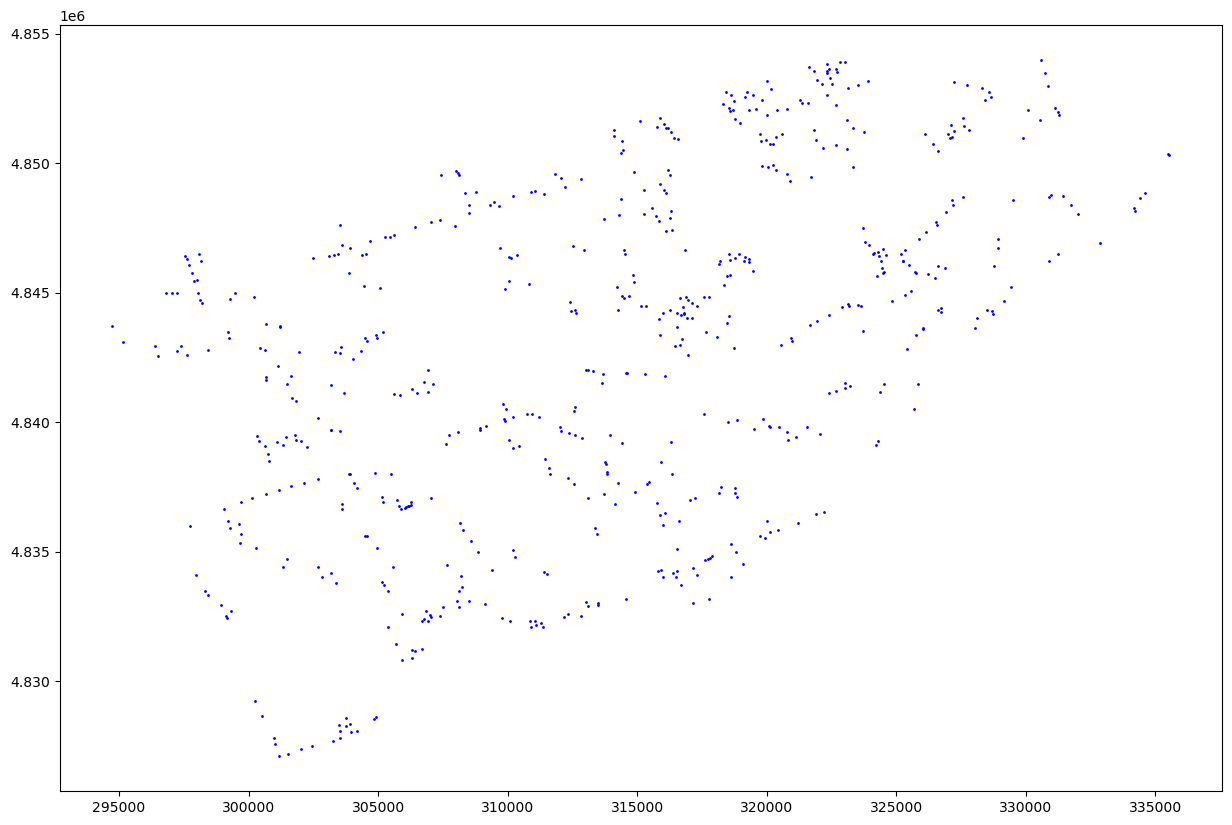

In [18]:
ax = bike_TE.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the bike_TE point data at the city block level


[(311200.0, 311800.0), (4834200.0, 4834800.0)]

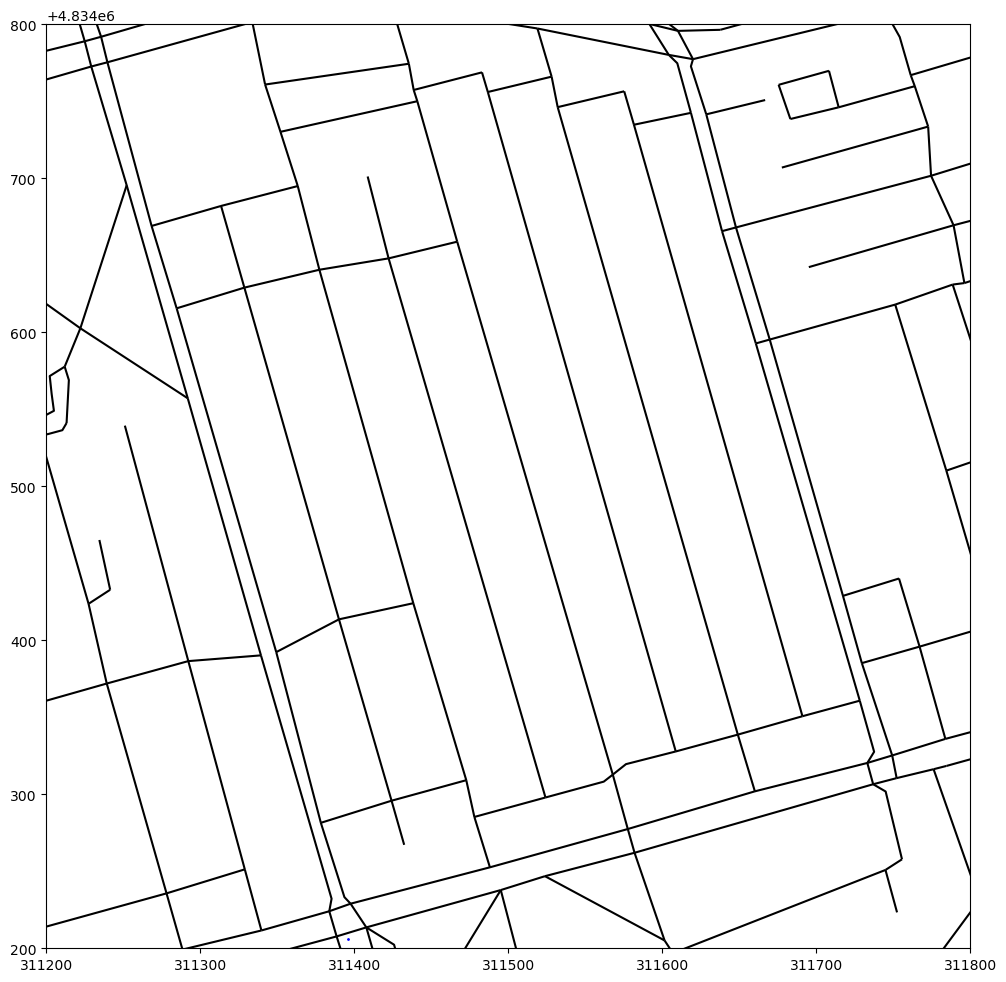

In [19]:
# plotting bike_TE layer with limits set
ax = bike_TE.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

## Neighbourhood Improvement Areas
Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [20]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("neighbourhood-improvement-areas-wgs84.zip")
nia

,AREA_ID,DATE_EFF,DATE_EXP,AREA_AT_ID,AREA_TP_ID,PARNT_AREA,AREA_TYPE,AREA_CL_ID,AREA_CL,AREA_S_CD,...,FEAT_CD,FEAT_C_DSC,TR_ID_CRT,TR_ID_EXP,X,Y,LONGITUDE,LATITUDE,OBJECTID,geometry
0,25886593,2014-05-12,3000-01-01,25926665,602,49885,CNBH,0,None,027,...,0,None,105211,-1,305679.417,4847086.588,-79.488883,43.765736,16491553.0,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,2014-05-12,3000-01-01,25926718,602,49885,CNBH,0,None,003,...,0,None,105211,-1,299670.030,4844005.846,-79.563491,43.737988,16492401.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,2014-05-12,3000-01-01,25926719,602,49885,CNBH,0,None,055,...,0,None,105211,-1,316874.178,4840655.317,-79.349984,43.707749,16492417.0,"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,2014-05-12,3000-01-01,25926708,602,49885,CNBH,0,None,028,...,0,None,105211,-1,304938.033,4841073.295,-79.498091,43.711609,16492241.0,"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,2014-05-12,3000-01-01,25926709,602,49885,CNBH,0,None,139,...,0,None,105211,-1,327594.737,4844116.308,-79.216813,43.738652,16492257.0,"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."
5,25886994,2014-05-12,3000-01-01,25926710,602,49885,CNBH,0,None,085,...,0,None,105211,-1,309678.766,4832752.918,-79.439338,43.636700,16492273.0,"POLYGON ((-79.42778 43.62979, -79.42948 43.630..."
6,25886342,2014-05-12,3000-01-01,25926716,602,49885,CNBH,0,None,061,...,0,None,105211,-1,321236.202,4839247.968,-79.295901,43.694998,16492369.0,"POLYGON ((-79.28776 43.68978, -79.29269 43.688..."
7,25886613,2014-05-12,3000-01-01,25926790,602,49885,CNBH,0,None,021,...,0,None,105211,-1,300261.014,4846330.825,-79.556175,43.758920,16493553.0,"POLYGON ((-79.58064 43.76302, -79.57754 43.763..."
8,25886658,2014-05-12,3000-01-01,25926791,602,49885,CNBH,0,None,022,...,0,None,105211,-1,301371.929,4844609.257,-79.542367,43.743430,16493569.0,"POLYGON ((-79.52628 43.73640, -79.52649 43.736..."
9,25886693,2014-05-12,3000-01-01,25926778,602,49885,CNBH,0,None,044,...,0,None,105211,-1,318269.615,4841566.821,-79.332646,43.715930,16493361.0,"POLYGON ((-79.33791 43.70770, -79.33788 43.707..."


In [21]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia

,area_id,area_s_cd,area_name,geometry
0,25886593,027,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,003,Thistletown-Beaumond Heights (3),"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,055,Thorncliffe Park (55),"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,028,Rustic (28),"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,139,Scarborough Village (139),"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."
5,25886994,085,South Parkdale (85),"POLYGON ((-79.42778 43.62979, -79.42948 43.630..."
6,25886342,061,Taylor-Massey (61),"POLYGON ((-79.28776 43.68978, -79.29269 43.688..."
7,25886613,021,Humber Summit (21),"POLYGON ((-79.58064 43.76302, -79.57754 43.763..."
8,25886658,022,Humbermede (22),"POLYGON ((-79.52628 43.73640, -79.52649 43.736..."
9,25886693,044,Flemingdon Park (44),"POLYGON ((-79.33791 43.70770, -79.33788 43.707..."


In [22]:
nia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore Neighbourhood Improvement Areas

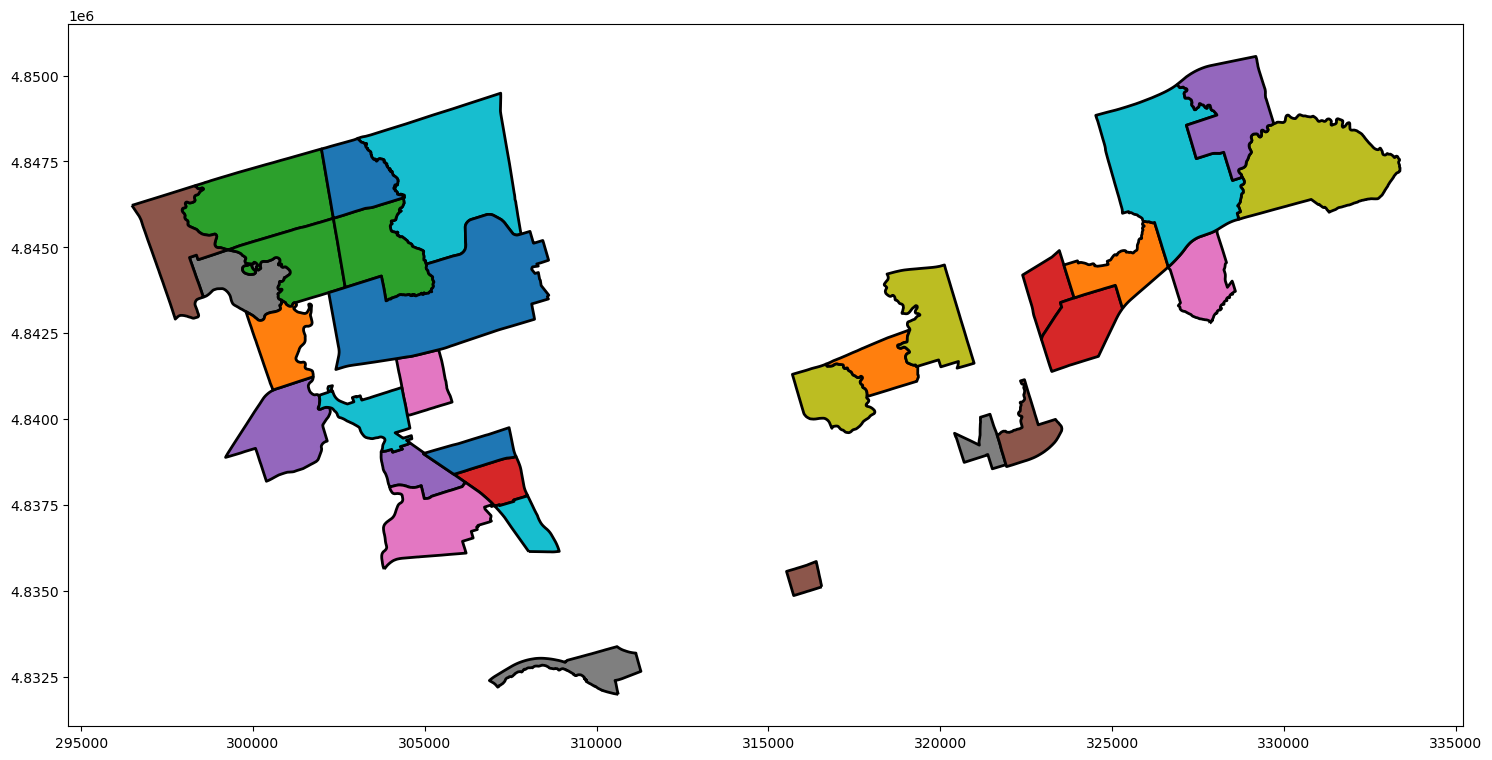

In [24]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)

# Step 2: Build Pandana Network
Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers.

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

## Create Network Graph Code Function

In [25]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Create a network graph from the function above


In [26]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [27]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [28]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges

,from,to,forward,FIELD_3,FIELD_9,FIELD_1,FIELD_7,visited,length,FIELD_5,FIELD_8,FIELD_4,FIELD_6,geometry,to_node,from_node
0,"(299647.48, 4843993.305)","(299730.645, 4843949.766)",1,Local,None,696841,None,0,93.871829,Sidewalk on both sides,NaN,7,0,LINESTRING (299647.4801773648 4843993.30454792...,64150,36406
1,"(299647.48, 4843993.305)","(299602.64, 4844063.116)",1,Local,None,780939,None,0,82.971471,Sidewalk on both sides,NaN,7,0,LINESTRING (299602.6398887987 4844063.11581814...,25903,36406
2,"(299730.645, 4843949.766)","(299811.934, 4843907.77)",1,Local,None,722552,None,0,91.496355,No sidewalk on either side,NaN,3,0,LINESTRING (299730.64456459746 4843949.7660014...,39647,64150
3,"(299730.645, 4843949.766)","(299783.527, 4844033.238)",1,Local,None,738428,None,0,98.813743,Sidewalk on both sides,NaN,7,0,LINESTRING (299730.64456459746 4843949.7660014...,49430,64150
4,"(299319.487, 4832701.797)","(299351.915, 4832699.012)",1,Collector,None,696842,None,0,32.547298,Sidewalk on both sides,NaN,7,0,LINESTRING (299319.48713045556 4832701.7969447...,21177,43712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87091,"(327229.441, 4852966.294)","(327237.367, 4853015.687)",1,Minor Arterial,None,781934,None,0,50.025415,Sidewalk on both sides,NaN,7,0,LINESTRING (327229.4406646615 4852966.29367340...,20725,21457
87092,"(307051.475, 4834711.445)","(307056.406, 4834694.336)",1,Local,None,781991,None,0,17.805959,Sidewalk on both sides,NaN,7,0,LINESTRING (307051.4754708746 4834711.44545915...,46428,1087
87093,"(309342.013, 4837279.095)","(309284.58, 4837260.629)",1,Laneway,None,783712,None,0,60.328226,Laneway without any sidewalks,NaN,10,0,LINESTRING (309284.58048275416 4837260.6294444...,60133,16828
87094,"(321401.322, 4836954.751)","(321449.636, 4836949.596)",1,Laneway,None,783735,None,0,48.588611,Laneway without any sidewalks,NaN,10,0,LINESTRING (321401.32159512583 4836954.7514345...,59081,8076


### Creating and Saving Pandana Network
Create the Pandana Network and save the file in case you lose the network in memory

In [29]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')

### Reading Pandana Network file
This step is only required if you do not already have transit_ped_net in memory

In [30]:
transit_ped_net = pdna.Network.from_hdf5('walkability.hd5')

### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [31]:
#precompute a given horizon distance of 1000 meters
transit_ped_net.precompute(1000)
transit_ped_net.edges_df

,from,to,length
0,36406,64150,93.871829
1,36406,25903,82.971471
2,64150,39647,91.496355
3,64150,49430,98.813743
4,43712,21177,32.547298
...,...,...,...
87091,21457,20725,50.025415
87092,1087,46428,17.805959
87093,16828,60133,60.328226
87094,8076,59081,48.588611


#### Get the nearest pednet intersection node ids for each point from the bike_TE and MERGED layers

In [32]:
#get node_ids for points for each layer
x, y = MERGED.x, MERGED.y
MERGED["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(MERGED["node_ids"], name="MERGED")

# using x and y coordinates from bike_TE that are utm nad27
x, y = bike_TE.x, bike_TE.y
bike_TE["node_ids"] = transit_ped_net.get_node_ids(x, y)

#### Get 10 nearest MERGED points
The 10 nearest MERGEDs will be determined.

In [33]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("MERGED", maxdistance , n, MERGED.x, MERGED.y)
MERGED_walk_distances = transit_ped_net.nearest_pois(maxdistance , "MERGED", num_pois=n, include_poi_ids=False)

MERGED_walk_distances

,1,2,3,4,5,6,7,8,9,10
0,117.717003,194.886993,805.711975,831.758972,831.758972,997.656982,1037.240967,1216.671997,1229.557983,1396.671997
1,0.000000,578.999023,596.903015,936.593994,1059.620972,1092.590942,1097.404053,1247.916016,1247.916016,1504.416992
2,480.463013,1245.493042,1340.719971,1551.692017,1734.816040,1751.748047,1751.748047,1955.875977,2004.718994,2043.421021
3,487.529999,528.705017,548.679993,601.640015,801.276001,801.276001,838.419006,877.505981,1094.708984,1199.312988
4,543.125000,543.125000,611.471008,666.297974,808.945984,1229.531982,1443.529053,1443.529053,1794.136963,1881.416016
...,...,...,...,...,...,...,...,...,...,...
64710,404.274994,485.333008,485.333008,494.292999,499.760986,764.426025,902.218994,1009.200012,1058.219971,1124.661011
64711,254.727997,621.460999,642.802979,733.242004,841.223022,841.223022,856.921997,973.551025,1076.338989,1293.927002
64712,1092.463989,1222.989014,1590.084961,1592.456055,2057.233887,2099.543945,2227.733887,2253.731934,2306.155029,2306.155029
64713,769.059998,1141.704956,1183.921997,1513.063965,1537.572998,1539.066040,1539.066040,1578.115967,1604.527954,1604.527954


#### Renaming columns

In [34]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

MERGED_walk_distances.columns = columns
MERGED_walk_distances

,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,117.717003,194.886993,805.711975,831.758972,831.758972,997.656982,1037.240967,1216.671997,1229.557983,1396.671997
1,0.000000,578.999023,596.903015,936.593994,1059.620972,1092.590942,1097.404053,1247.916016,1247.916016,1504.416992
2,480.463013,1245.493042,1340.719971,1551.692017,1734.816040,1751.748047,1751.748047,1955.875977,2004.718994,2043.421021
3,487.529999,528.705017,548.679993,601.640015,801.276001,801.276001,838.419006,877.505981,1094.708984,1199.312988
4,543.125000,543.125000,611.471008,666.297974,808.945984,1229.531982,1443.529053,1443.529053,1794.136963,1881.416016
...,...,...,...,...,...,...,...,...,...,...
64710,404.274994,485.333008,485.333008,494.292999,499.760986,764.426025,902.218994,1009.200012,1058.219971,1124.661011
64711,254.727997,621.460999,642.802979,733.242004,841.223022,841.223022,856.921997,973.551025,1076.338989,1293.927002
64712,1092.463989,1222.989014,1590.084961,1592.456055,2057.233887,2099.543945,2227.733887,2253.731934,2306.155029,2306.155029
64713,769.059998,1141.704956,1183.921997,1513.063965,1537.572998,1539.066040,1539.066040,1578.115967,1604.527954,1604.527954


#### Calculating walk distance from bike_TE points to MERGEDs and get each point id from MERGED.


In [35]:
for i in range(10):
    bike_TE['d_ttcstop_{}'.format(i)]=bike_TE['node_ids'].map(MERGED_walk_distances['d_ttcstop_{}'.format(i)])
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry,node_ids,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (324490.575 4845745.976),60446,366.023010,634.697021,734.734985,734.734985,734.734985,734.734985,784.552979,815.594971,986.513977,1085.045044
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (324509.299 4845783.844),37608,332.966003,601.216003,768.231018,768.231018,768.231018,768.231018,814.568970,849.091003,1016.530029,1051.548950
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (325171.943 4846501.242),54149,638.119019,638.119019,638.119019,638.119019,850.609009,852.663025,1008.049988,1080.406006,1080.406006,1392.767944
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (325867.816 4847071.148),28241,535.445007,538.476013,1027.512939,1027.512939,1032.015015,1071.765015,1222.514038,1253.702026,1555.995972,1555.995972
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (326155.862 4847327.287),10974,458.731995,668.445984,880.507019,890.716980,1295.338989,1388.687988,1388.687988,1583.688965,1644.494995,1783.020020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (324099.656 4846505.642),30360,524.283020,1161.938965,1315.365967,1315.365967,1328.511963,1355.119995,1596.076050,1765.637939,1765.637939,1765.637939
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (327626.347 4851423.822),38609,505.792999,560.004028,622.142029,622.142029,720.398987,720.398987,811.463989,1159.119019,1284.569946,1319.192017
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (320364.047 4851028.272),43529,199.742004,199.742004,421.730011,608.960022,608.960022,736.828003,911.094971,911.094971,1026.223022,1258.399048
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (318979.446 4851548.344),39872,392.795013,705.296997,769.348022,832.518982,832.518982,1164.838013,1188.478027,1188.478027,1226.817993,1279.067993


#### Calculate minutes fields based on distances
We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [36]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

bike_TE['m_ttcstop_0'] = bike_TE.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
bike_TE['m_ttcstop_1'] = bike_TE.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
bike_TE['m_ttcstop_2'] = bike_TE.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
bike_TE['m_ttcstop_3'] = bike_TE.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
bike_TE['m_ttcstop_4'] = bike_TE.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
bike_TE['m_ttcstop_5'] = bike_TE.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
bike_TE['m_ttcstop_6'] = bike_TE.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
bike_TE['m_ttcstop_7'] = bike_TE.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
bike_TE['m_ttcstop_8'] = bike_TE.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
bike_TE['m_ttcstop_9'] = bike_TE.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry,node_ids,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (324490.575 4845745.976),60446,...,5.083653,8.815236,10.204653,10.204653,10.204653,10.204653,10.896569,11.327708,13.701583,15.070070
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (324509.299 4845783.844),37608,...,4.624528,8.350222,10.669875,10.669875,10.669875,10.669875,11.313458,11.792931,14.118473,14.604847
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (325171.943 4846501.242),54149,...,8.862764,8.862764,8.862764,8.862764,11.814014,11.842542,14.000694,15.005639,15.005639,19.343999
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (325867.816 4847071.148),28241,...,7.436736,7.478834,14.271013,14.271013,14.333542,14.885625,16.979362,17.412528,21.611055,21.611055
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (326155.862 4847327.287),10974,...,6.371278,9.283972,12.229264,12.371069,17.990819,19.287333,19.287333,21.995680,22.840208,24.764167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (324099.656 4846505.642),30360,...,7.281709,16.138041,18.268972,18.268972,18.451555,18.821111,22.167723,24.522749,24.522749,24.522749
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (327626.347 4851423.822),38609,...,7.024903,7.777834,8.640862,8.640862,10.005541,10.005541,11.270333,16.098875,17.841249,18.322111
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (320364.047 4851028.272),43529,...,2.774195,2.774195,5.857361,8.457778,8.457778,10.233722,12.654097,12.654097,14.253098,17.477765
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (318979.446 4851548.344),39872,...,5.455486,9.795792,10.685389,11.562764,11.562764,16.178306,16.506639,16.506639,17.039139,17.764833


# Step 3: Visualize Walking Times
In this step we will create a series of visulations illustrating the walking times to the nearest MERGED across the pedestrian network.

## Walking Times To Closest MERGED
In this section we will create a chloropleth map showing the walk times to the closest MERGED across the City of Toronto. As expected the shortest walk times are along majorial aerterials where MERGEDs are located as shown in the second map below where the MERGEDs are colour coded red.

Text(0.5, 1.0, 'Walking Times To Closest MERGED')

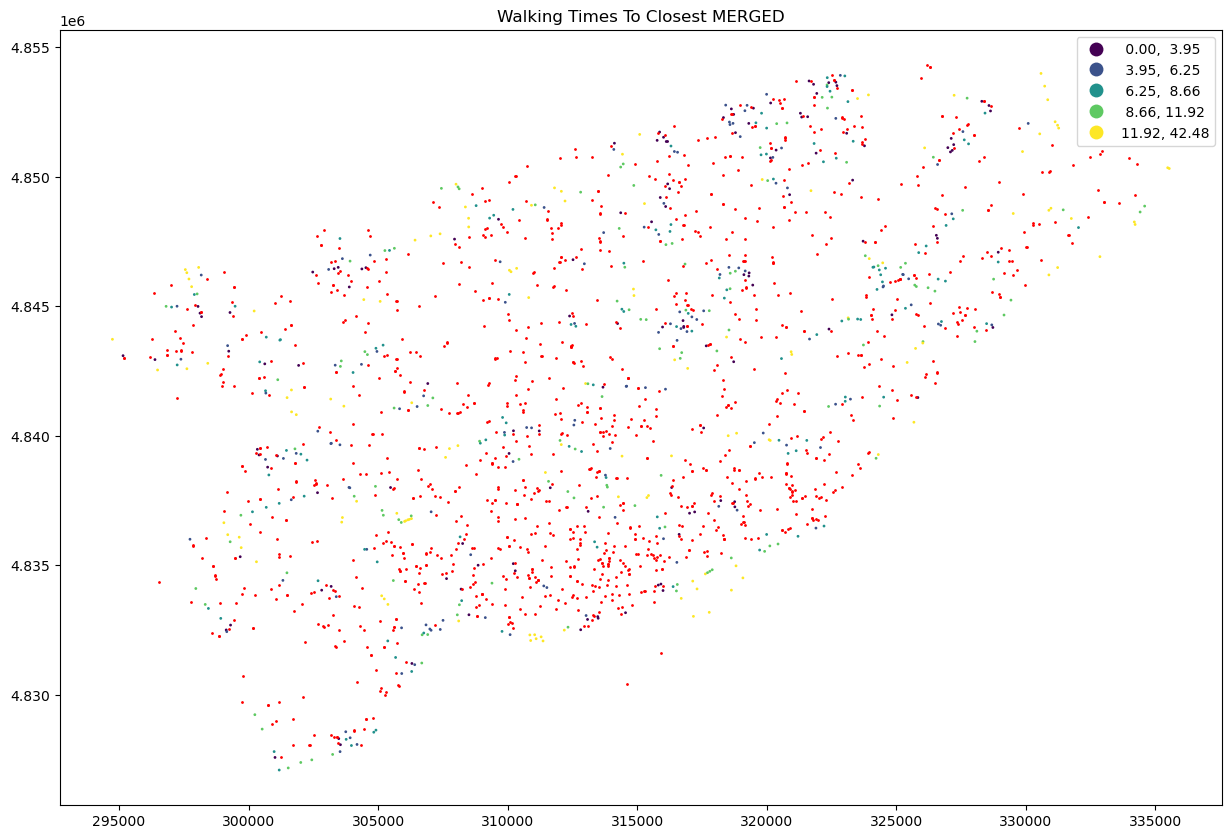

In [37]:
# Walking times To closest MERGED with MERGEDs added
import mapclassify
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
MERGED.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest MERGED')

## Walking Times To Closest MERGED with Neighbourhood Improvement Areas

In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

## Get the Neighbourhood Improvement Area centre points

To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [38]:
# Here we find the center points, copy our original df to a new df, and then set
# the geometry column to the newly created center points column
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

Text(0.5, 1.0, 'Walking Times To Closest MERGED \n within Neighbourhood Improvement Areas')

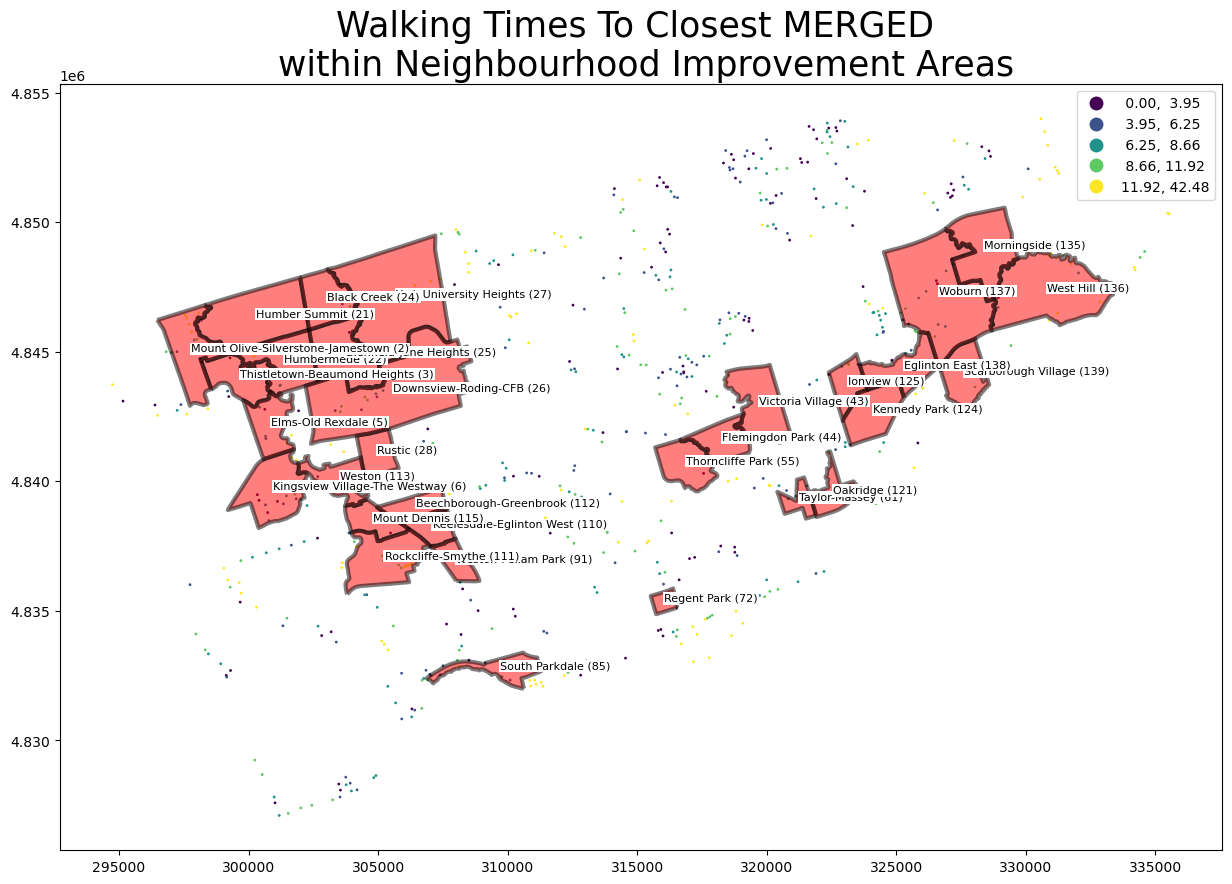

In [39]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest MERGED \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

# bike_TEes within Neighbourhood Improvement Areas

We will now perform a spatial join between Neighbourhood Improvement Area layer and bike_TE layer in order to allocate bike_TEes to Neighbourhood Improvement Areas.

In [40]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with bike_TE points
nia_bike_TE = gpd.sjoin(nia, bike_TE, op='intersects', how='left')
nia_bike_TE

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\IPython\core\interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,12.081195,15.505569,16.328834,16.339764,17.477778,17.701528,17.701528,20.150389,21.624527,24.991486
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,13.264097,14.469681,15.658320,16.254098,16.559916,18.683848,18.729084,19.304611,19.943653,21.173333
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,0.313944,0.313944,7.168570,11.476361,11.639431,13.231875,15.525792,15.705639,15.931973,16.714986
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,5.989306,9.727278,9.727278,13.220361,13.246042,15.275708,17.569624,20.572098,21.052763,21.976596
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,10.295028,11.253042,15.440055,16.613320,17.171611,17.368028,17.368028,18.337806,22.403097,28.045305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,4.427764,7.848889,10.350153,17.913486,19.009430,20.285611,22.447194,23.072903,23.103083,23.931944
29,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,5.575792,6.357597,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195
29,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,5.575792,6.357597,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195
29,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,5.821847,9.047667,10.796653,19.450945,19.657778,23.743098,32.270043,32.327972,32.409346,32.409346


# Count of bike_TEes in Neighbourhood Improvement Areas

We will now do a count of bike_TEes within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [41]:
# count of bike_TEes assigned to each Neighbourhood Improvement Area
value_counts = nia_bike_TE.area_name.value_counts()
value_counts

Woburn (137)                             14
Mount Olive-Silverstone-Jamestown (2)    12
Rockcliffe-Smythe (111)                  12
York University Heights (27)             11
Kingsview Village-The Westway (6)        11
Downsview-Roding-CFB (26)                10
West Hill (136)                           8
South Parkdale (85)                       6
Elms-Old Rexdale (5)                      6
Black Creek (24)                          6
Ionview (125)                             5
Humbermede (22)                           4
Weston (113)                              4
Victoria Village (43)                     3
Thistletown-Beaumond Heights (3)          3
Scarborough Village (139)                 3
Taylor-Massey (61)                        3
Glenfield-Jane Heights (25)               2
Mount Dennis (115)                        2
Oakridge (121)                            2
Eglinton East (138)                       2
Thorncliffe Park (55)                     1
Rustic (28)                     

In [42]:
# count of bike_TEes assigned to each Neighbourhood Improvement Area
value_counts = nia_bike_TE.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_bike_TE_count
nia_bike_TE_counts = value_counts.rename_axis('area_name').reset_index(name='nia_bike_TE_count')
nia_bike_TE_counts

# merge nia_bike_TE_counts with nia_bike_TE using the area_name which is shared by both dataframes
nia_bike_TE = pd.merge(nia_bike_TE, nia_bike_TE_counts)

nia_bike_TE

,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_bike_TE_count
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,15.505569,16.328834,16.339764,17.477778,17.701528,17.701528,20.150389,21.624527,24.991486,11
1,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,14.469681,15.658320,16.254098,16.559916,18.683848,18.729084,19.304611,19.943653,21.173333,11
2,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,0.313944,7.168570,11.476361,11.639431,13.231875,15.525792,15.705639,15.931973,16.714986,11
3,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,9.727278,9.727278,13.220361,13.246042,15.275708,17.569624,20.572098,21.052763,21.976596,11
4,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,11.253042,15.440055,16.613320,17.171611,17.368028,17.368028,18.337806,22.403097,28.045305,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,7.848889,10.350153,17.913486,19.009430,20.285611,22.447194,23.072903,23.103083,23.931944,4
135,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,6.357597,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195,4
136,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,6.357597,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195,4
137,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,9.047667,10.796653,19.450945,19.657778,23.743098,32.270043,32.327972,32.409346,32.409346,4


<AxesSubplot:title={'center':'bike_TE Count in Neighbourhood Improvement Areas'}, xlabel='Neighbourhood Improvement Areas', ylabel='Number'>

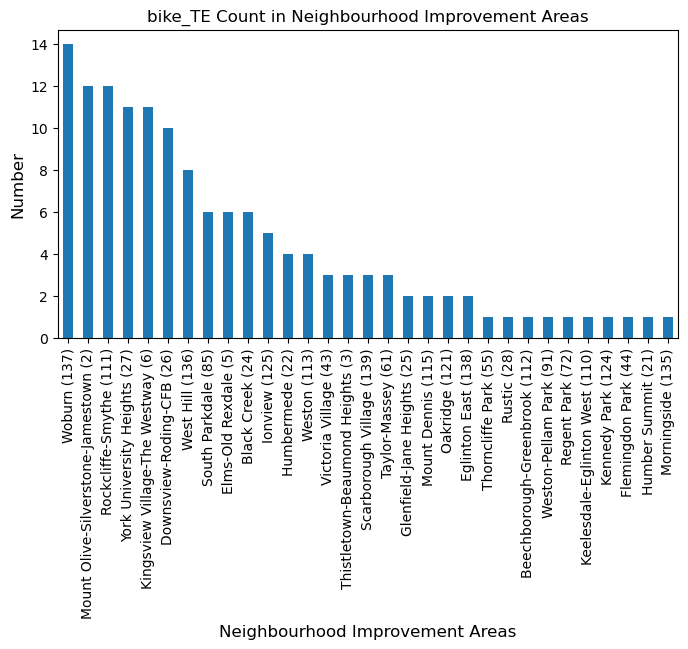

In [43]:
# distribution of bike_TEes in nia_bike_TE

#plot
plt.figure(figsize=(8,4))

plt.title("bike_TE Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_bike_TE.area_name.value_counts().plot.bar()

Text(0.5, 1.0, 'Walking Times To Closest MERGED')

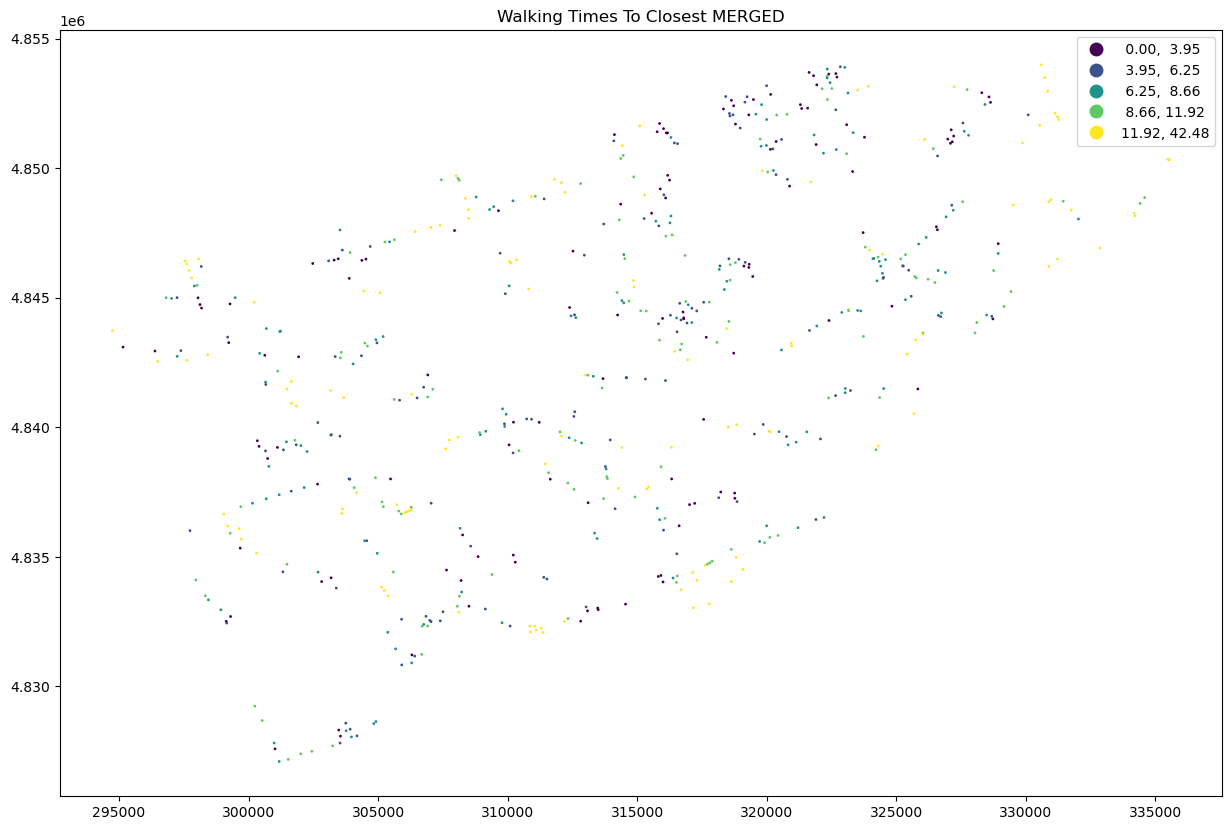

In [44]:
# Walking Times To Closest MERGED
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest MERGED')

# Average Walking Times To Closest MERGED in Neighbourhood Improvement Areas

We will now use the mean function to calculate the mean walking time to the closest MERGED for each of the Neighbourhood Improvement Areas.

In [45]:
mins_avgs = nia_bike_TE.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)                  NaN
Black Creek (24)                          4.504419
Downsview-Roding-CFB (26)                 8.003232
Eglinton East (138)                       8.091257
Elms-Old Rexdale (5)                      7.838477
Flemingdon Park (44)                           NaN
Glenfield-Jane Heights (25)               3.040590
Humber Summit (21)                        6.173180
Humbermede (22)                           9.248673
Ionview (125)                             9.831325
Keelesdale-Eglinton West (110)                 NaN
Kennedy Park (124)                        5.638250
Kingsview Village-The Westway (6)         4.680279
Morningside (135)                        13.354791
Mount Dennis (115)                        6.245007
Mount Olive-Silverstone-Jamestown (2)     9.551099
Oakridge (121)                            6.716000
Regent Park (72)                          5.616305
Rockcliffe-Smythe (111)                  12.323373
Rustic (28)          

In [46]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_bike_TE with nia_addr_avg_min using area_name
nia_bike_TE = pd.merge(nia_bike_TE, nia_addr_avg_min)

nia_bike_TE

,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_bike_TE_count,nia_addr_avg_min
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,16.328834,16.339764,17.477778,17.701528,17.701528,20.150389,21.624527,24.991486,11,11.143571
1,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,15.658320,16.254098,16.559916,18.683848,18.729084,19.304611,19.943653,21.173333,11,11.143571
2,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,7.168570,11.476361,11.639431,13.231875,15.525792,15.705639,15.931973,16.714986,11,11.143571
3,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,9.727278,13.220361,13.246042,15.275708,17.569624,20.572098,21.052763,21.976596,11,11.143571
4,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,15.440055,16.613320,17.171611,17.368028,17.368028,18.337806,22.403097,28.045305,11,11.143571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,10.350153,17.913486,19.009430,20.285611,22.447194,23.072903,23.103083,23.931944,4,5.350299
135,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195,4,5.350299
136,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,11.796931,14.625444,17.580653,19.618583,23.824348,23.824348,24.283861,24.409195,4,5.350299
137,25886362,113,Weston (113),"POLYGON ((304561.646 4839316.030, 304547.480 4...",POINT (303532.765 4840091.467),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,10.796653,19.450945,19.657778,23.743098,32.270043,32.327972,32.409346,32.409346,4,5.350299


<AxesSubplot:xlabel='area_name'>

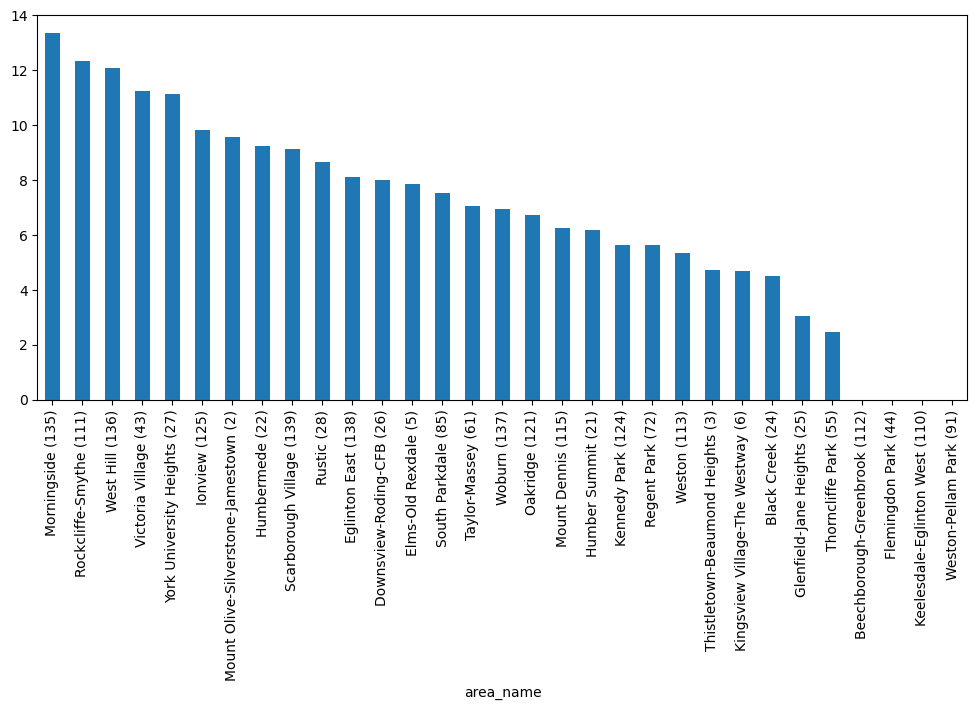

In [47]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_bike_TE_bar = nia_bike_TE.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_bike_TE_bar.sort_values(ascending=False).plot.bar()

# Plot Average Walking times to the Closest MERGED for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

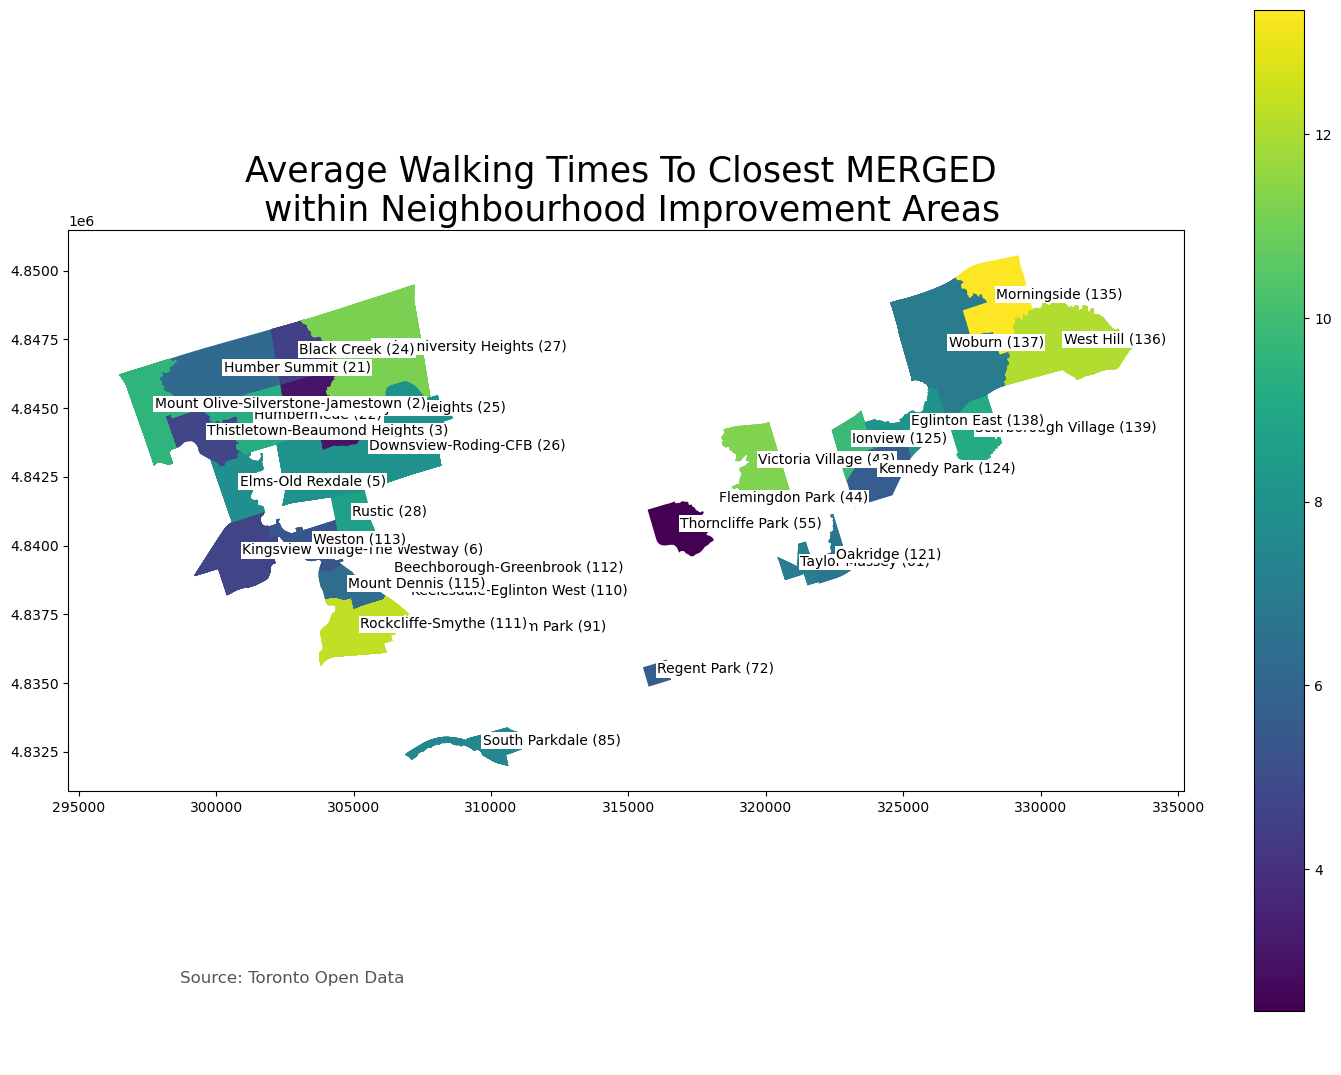

In [48]:
# plot Average Walking Times To Closest MERGED in Neighbourhood Improvement Areas
ax = nia_bike_TE.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest MERGED \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Get bounds of each Neighbourhood Improvement Area polygon

We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [49]:
# index_left and area_name
nia.area_name

0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                         Regen

In [50]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name
nia_area_name = nia.area_name.iloc[4]
nia_area_name

'Scarborough Village (139)'

# Plotting Neighbourhood Improvement Area using bounding box co-ordinates

Text(0.1, 0.05, 'Source: Toronto Open Data')

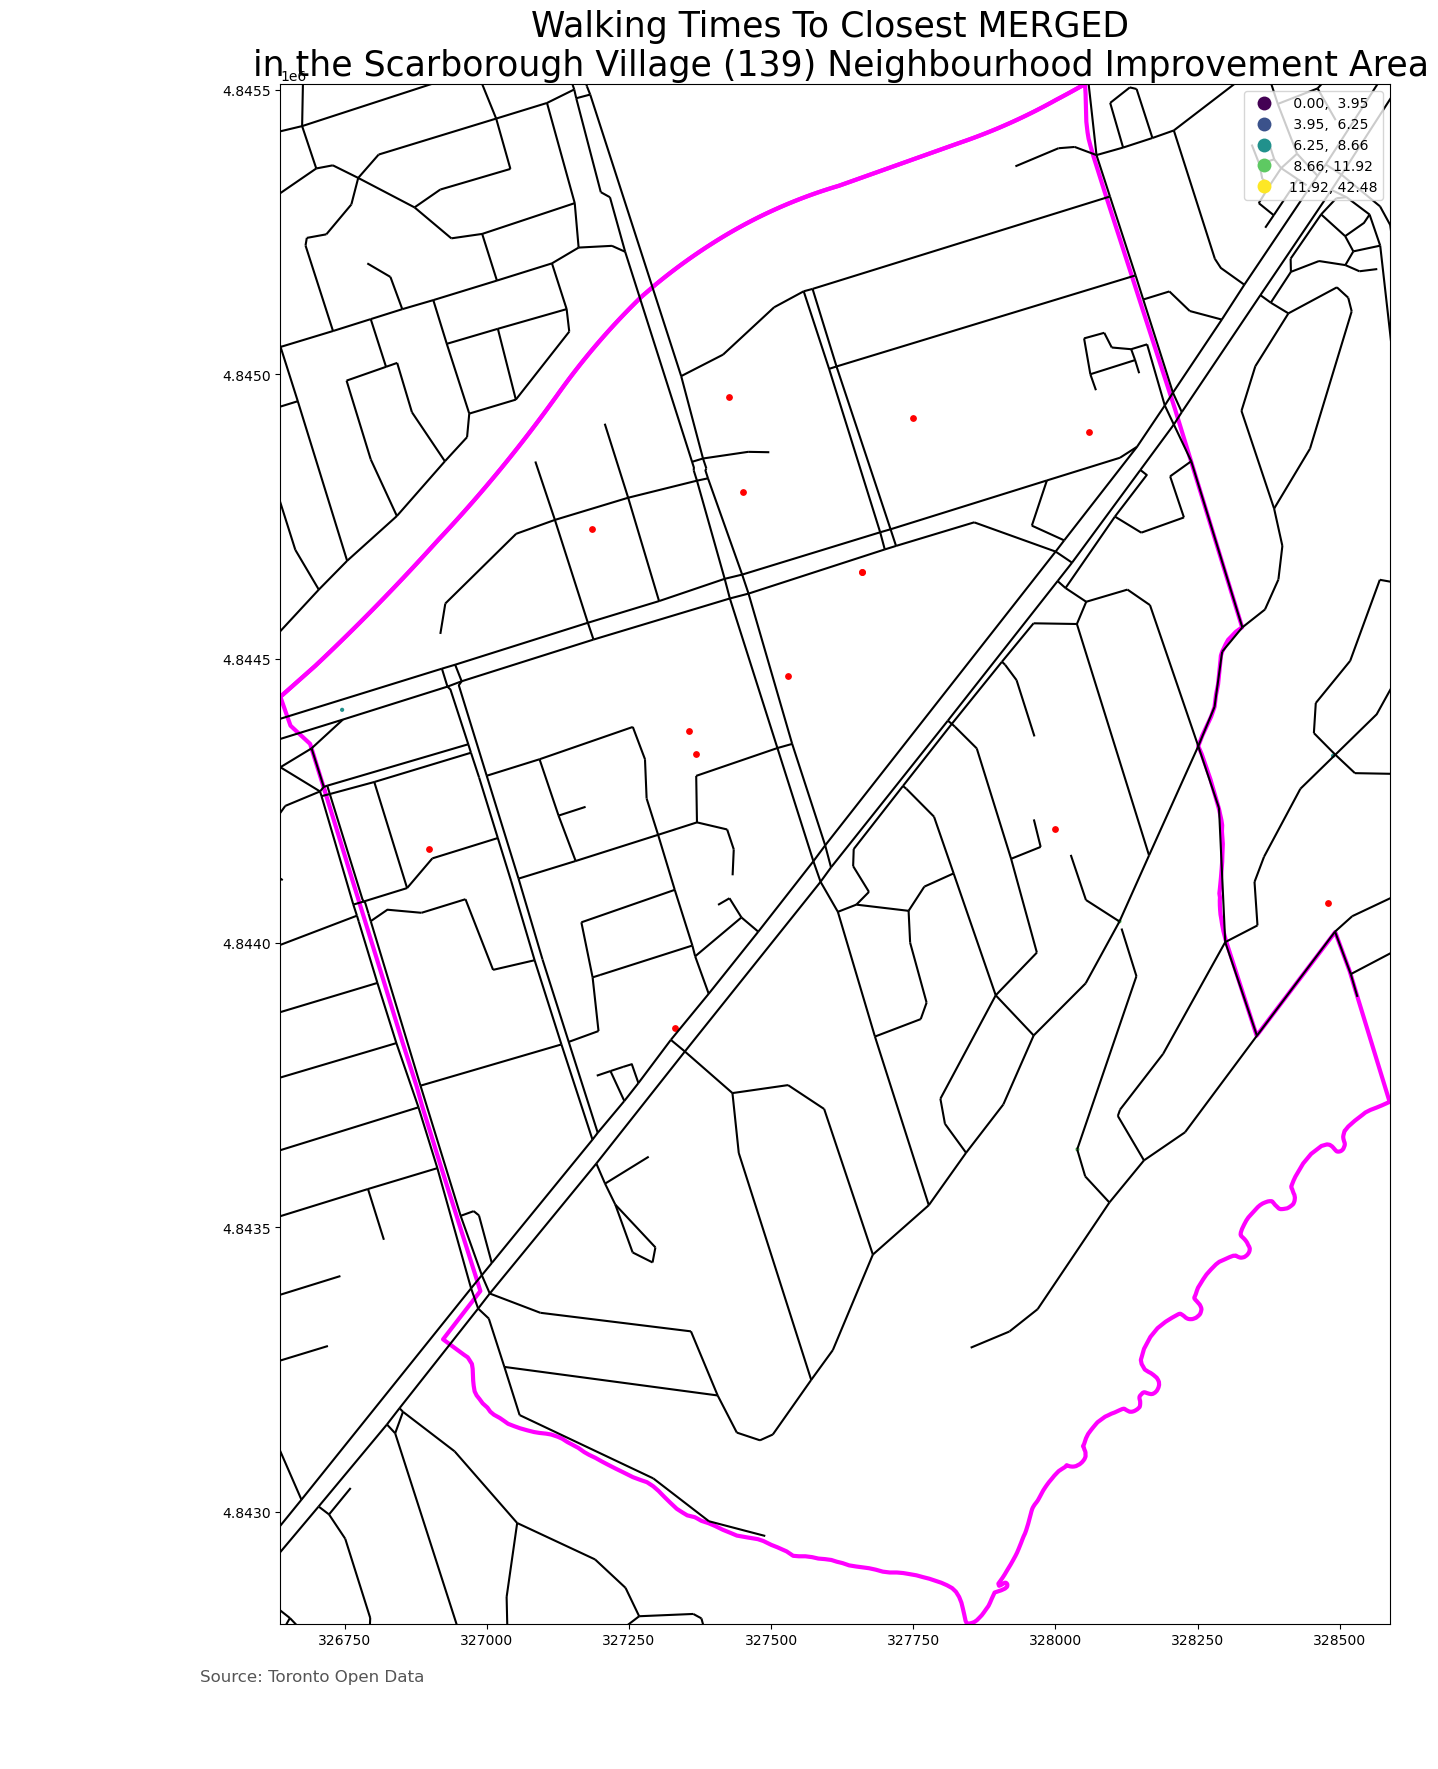

In [51]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = bike_TE.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
MERGED.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest MERGED \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./MERGED_walkability.png", dpi=300)